In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from libs.factuality.factcheck import FactualityCheck
from postprocessing import bias

# Setup

In [3]:
FACTUALITY_PATH = '../results/factuality'
APS_OA_DATA_TAR_GZ = '../../APS/data/final_dataset.tar.gz'
APS_OS_DISCIPLINE_DEMOGRAPHICS = '../results/metadata/disciplines_author_demographics.csv'
PLOTS_PATH = '../results/plots'

In [4]:
vis.sns_reset()
vis.sns_paper_style()

## Data

In [5]:
df_llm_real_authors = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_author.csv"), index_col=0) for model in constants.LLMS], ignore_index=True)
df_llm_real_authors.shape

(138439, 33)

In [6]:
df_all_authors_demographics = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_DEMOGRAPHICS_FN)
df_all_authors_demographics.shape

(481012, 14)

In [7]:
df_all_authors_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_STATS_FN)
df_all_authors_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)
df_all_authors_stats.shape

(481012, 30)

In [8]:
df_all_institutions = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_INSTITUTIONS_FN)
df_all_institutions.shape

(110071, 14)

In [9]:
df_all_authors_institutions = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_INSTITUTION_YEAR_FN)
df_all_authors_institutions.shape

(8374715, 3)

In [10]:
df_gt_stats = io.read_csv(APS_OS_DISCIPLINE_DEMOGRAPHICS, index_col=0, header=[0, 1])
df_gt_stats.shape

(17, 19)

In [11]:
df_gt_stats.query("label in ['Condensed Matter & Materials Physics','Physics Education Research']")[['unique_authors','gender_counts','gender_fractions']]


# [['unique_authors','ethnicity_counts','ethnicity_fractions']]

unique_authors gender_counts         \
                                     unique_authors        Female   Male   
label                                                                      
Condensed Matter & Materials Physics          86319          7406  36819   
Physics Education Research                     1182           292    497   

                                                    gender_fractions  \
                                     Unisex Unknown           Female   
label                                                                  
Condensed Matter & Materials Physics   8749   33327         0.085816   
Physics Education Research              133     260         0.247039   

                                                                    
                                          Male    Unisex   Unknown  
label                                                               
Condensed Matter & Materials Physics  0.426635  0.101378  0.386172  
Physics Education Research            0.420474  0.112521  0.219966

# Ground-truth (APS-OA)

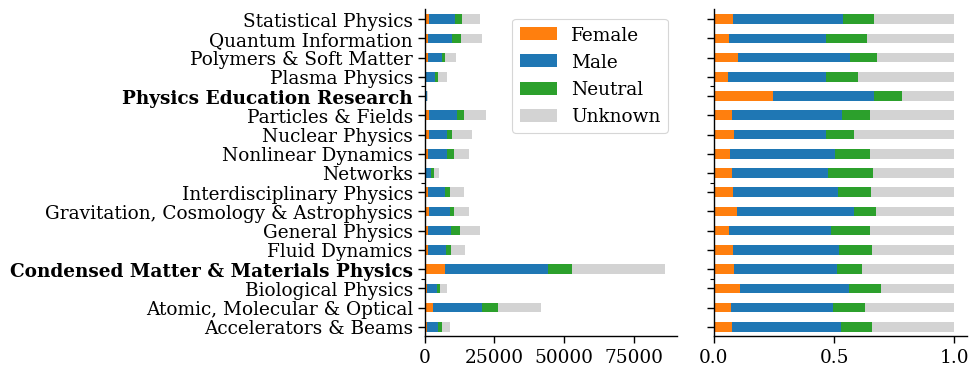

In [12]:
attribute = 'gender'
fn = io.path_join(PLOTS_PATH, f'app_gt_demographics_{attribute}.pdf')
vis.plot_gt_demographics(df_gt_stats, attribute, fn=fn, figsize=(10, 4))

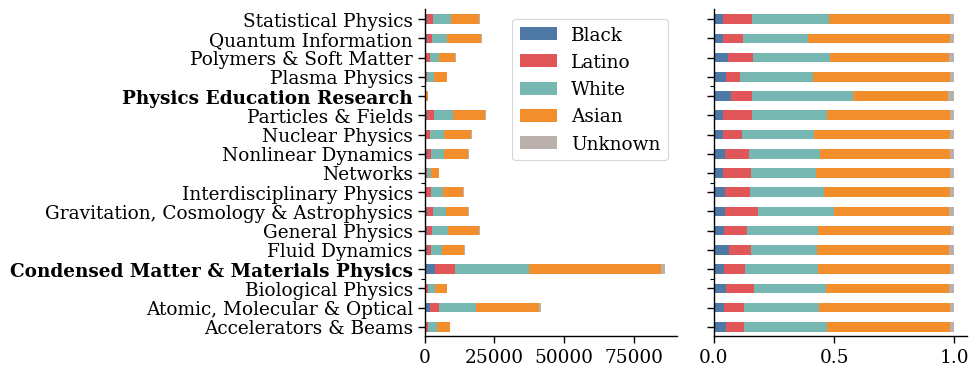

In [13]:
attribute = 'ethnicity'
fn = io.path_join(PLOTS_PATH, f'app_gt_demographics_{attribute}.pdf')
vis.plot_gt_demographics(df_gt_stats, attribute, fn=fn, figsize=(10, 4))

In [14]:
df_gt_stats.query("label in ['Condensed Matter & Materials Physics', 'Physics Education Research']")

unique_authors gender_counts         \
                                     unique_authors        Female   Male   
label                                                                      
Condensed Matter & Materials Physics          86319          7406  36819   
Physics Education Research                     1182           292    497   

                                                    gender_fractions  \
                                     Unisex Unknown           Female   
label                                                                  
Condensed Matter & Materials Physics   8749   33327         0.085816   
Physics Education Research              133     260         0.247039   

                                                                    \
                                          Male    Unisex   Unknown   
label                                                                
Condensed Matter & Materials Physics  0.426635  0.101378  0.386172   
Physics Education Research            0.420474  0.112521  0.219966   

                                     ethnicity_counts  \
                                                Asian   
label                                                   
Condensed Matter & Materials Physics            47376   
Physics Education Research                        463   

                                                                \
                                     Black or African American   
label                                                            
Condensed Matter & Materials Physics                      3652   
Physics Education Research                                  84   

                                                                        \
                                     Hispanic or Latino Unknown  White   
label                                                                    
Condensed Matter & Materials Physics               7409    1650  26214   
Physics Education Research                          104      34    497   

                                     ethnicity_fractions  \
                                                   Asian   
label                                                      
Condensed Matter & Materials Physics            0.548962   
Physics Education Research                      0.391709   

                                                                \
                                     Black or African American   
label                                                            
Condensed Matter & Materials Physics                  0.042317   
Physics Education Research                            0.071066   

                                                                             
                                     Hispanic or Latino   Unknown     White  
label                                                                        
Condensed Matter & Materials Physics           0.085851  0.019119  0.303751  
Physics Education Research                     0.087986  0.028765  0.420474

In [15]:
df_gt_stats.loc[:, ('gender_fractions_2', 'Female')] = df_gt_stats.apply(lambda row: row[('gender_counts', 'Female')] / (row[('gender_counts', 'Female')]+row[('gender_counts', 'Male')]+row[('gender_counts', 'Unisex')]), axis=1)
df_gt_stats.sort_values(('gender_fractions_2', 'Female'), ascending=False)

unique_authors gender_counts         \
                                      unique_authors        Female   Male   
label                                                                       
Physics Education Research                      1182           292    497   
Biological Physics                              8116           876   3675   
Polymers & Soft Matter                         11111          1113   5156   
Nuclear Physics                                17091          1432   6539   
Gravitation, Cosmology & Astrophysics          15791          1507   7669   
Condensed Matter & Materials Physics           86319          7406  36819   
Interdisciplinary Physics                      14149          1132   6145   
Fluid Dynamics                                 14565          1148   6402   
Statistical Physics                            19998          1576   9178   
Accelerators & Beams                            9253           716   4165   
Particles & Fields                             21934          1674  10010   
Atomic, Molecular & Optical                    41767          3015  17717   
Networks                                        5126           380   2051   
Nonlinear Dynamics                             16063          1072   7015   
Quantum Information                            20745          1325   8361   
Plasma Physics                                  8142           483   3309   
General Physics                                19842          1259   8381   

                                                     gender_fractions  \
                                      Unisex Unknown           Female   
label                                                                   
Physics Education Research               133     260         0.247039   
Biological Physics                      1074    2487         0.107988   
Polymers & Soft Matter                  1246    3594         0.100189   
Nuclear Physics                         2000    7119         0.083792   
Gravitation, Cosmology & Astrophysics   1480    5130         0.095464   
Condensed Matter & Materials Physics    8749   33327         0.085816   
Interdisciplinary Physics               1979    4888         0.080034   
Fluid Dynamics                          2026    4986         0.078835   
Statistical Physics                     2542    6699         0.078820   
Accelerators & Beams                    1212    3160         0.077380   
Particles & Fields                      2592    7656         0.076327   
Atomic, Molecular & Optical             5562   15463         0.072203   
Networks                                 958    1737         0.074132   
Nonlinear Dynamics                      2353    5620         0.066750   
Quantum Information                     3488    7565         0.063889   
Plasma Physics                          1087    3262         0.059329   
General Physics                         3221    6976         0.063467   

                                                                     \
                                           Male    Unisex   Unknown   
label                                                                 
Physics Education Research             0.420474  0.112521  0.219966   
Biological Physics                     0.453033  0.132396  0.306583   
Polymers & Soft Matter                 0.464128  0.112161  0.323521   
Nuclear Physics                        0.382621  0.117028  0.416559   
Gravitation, Cosmology & Astrophysics  0.485810  0.093754  0.324971   
Condensed Matter & Materials Physics   0.426635  0.101378  0.386172   
Interdisciplinary Physics              0.434460  0.139918  0.345588   
Fluid Dynamics                         0.439637  0.139129  0.342398   
Statistical Physics                    0.459015  0.127132  0.335034   
Accelerators & Beams                   0.450124  0.130985  0.341511   
Particles & Fields                     0.456411  0.118183  0.349079   
Atomic, Molecular & Optical            0.4

In [16]:
df_all_authors_demographics.head()

,id_author,created_date,updated_date,display_name,orcid,gender_nq,alternative_names,longest_name,last_name,first_name,ethnicity_dx,ethnicity_ec,ethnicity,gender
0,5053051063,2023-07-21,2024-11-04T00:46:12.391095,I. Ben‐Zvi,0000-0001-5583-0106,Male,"['I. Ben Zvi', 'I. Ben‐Zvi', 'I.B. Zvi', 'Ilan...",Ilan Ben‐Zvi,Ben‐Zvi,Ilan,White,Unknown,White,Male
1,5067224934,2023-07-21,2024-11-06T10:20:37.304362,T. Roser,0000-0001-5603-3192,Unknown,"['Roser', 'Th. Roser', 'Thomas Roser', 'T. Ros...",Thomas Roser,Roser,Thomas,White,White,White,Male
2,5012146130,2023-07-21,2024-11-01T15:52:34.664125,M. Ferrario,0000-0002-1105-0359,Male,"['M. Ferrario', 'Massimo Ferrario']",Massimo Ferrario,Ferrario,Massimo,White,White,White,Male
3,5051894783,2023-07-21,2024-11-01T03:49:19.361803,Jean-Luc Vay,0000-0002-0040-799X,Male,"['J. ‐L. Vay', 'Jean Luc Vay', 'J.‐Luc. Vay', ...",Jean Luc Vay,Vay,Jean,Black or African American,White,Black or African American,Male
4,5041648606,2023-07-21,2024-11-02T20:12:56.799035,A. Friedman,0000-0003-0421-2476,Male,"['A.M. Friedman', 'Alex Matthew Friedman', 'A....",Alex Matthew Friedman,Friedman,Alex,Asian,White,Asian,Male


Authors: 11 countries make up 80% of the total.


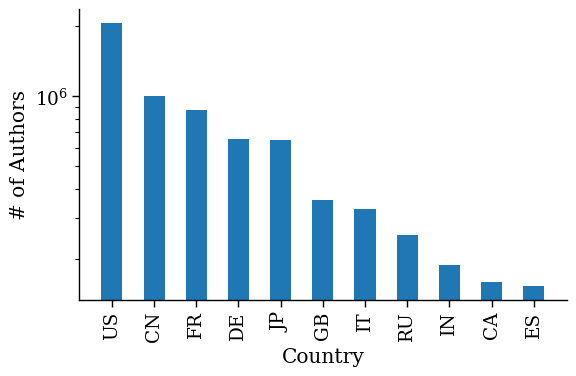

Institutions: 19 countries make up 80% of the total.


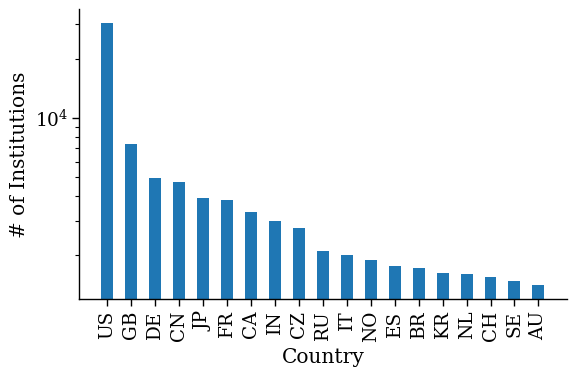

In [17]:
attribute = 'country_code'

# GT: authors per country
df_authors_per_country = df_all_authors_institutions.merge(df_all_institutions[['id_institution','cited_by_count','country_code','h_index']], how='left', on=['id_institution'], suffixes=['_author','_institution'])
df_authors_per_country = df_authors_per_country.groupby(attribute).size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)
df_authors_per_country.loc[:,'percent'] = df_authors_per_country['counts'] / df_authors_per_country['counts'].sum()
df_authors_per_country['cumulative_percent'] = df_authors_per_country['percent'].cumsum()

# GT: institutions per country
df_institutions_per_country = df_all_institutions.groupby(attribute).size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)
df_institutions_per_country.loc[:,'percent'] = df_institutions_per_country['counts'] / df_institutions_per_country['counts'].sum()
df_institutions_per_country['cumulative_percent'] = df_institutions_per_country['percent'].cumsum()


for i, (data, title) in enumerate(zip([df_authors_per_country, df_institutions_per_country], ['Authors', 'Institutions'])):

    fn = io.path_join(PLOTS_PATH, f'app_gt_institutions_{attribute}_{title.lower()}.pdf')

    # how many countries make up 80% of the total?
    threshold = 0.80
    top_countries = data.query("cumulative_percent <= @threshold")

    # Step 3: Output the number of countries
    num_countries = len(top_countries)
    print(f"{title}: {num_countries} countries make up {threshold*100:.0f}% of the total.")
    min_val = top_countries.iloc[-1]['counts']

    df = data.query('counts >= @min_val')

    vis.plot_barplot(data=df, 
                     x_col=attribute, y_col='counts', 
                     fn=fn, 
                     figsize=(6, 4),
                     x_order=df[attribute].tolist(),
                     yscale='log',
                     legend=False,
                     sharey=False,
                     xlabel='Country',
                     ylabel=f'# of {title}',
                     xtickrot=90)
    



# In LLM results

## Gender 

### Across all tasks

In [18]:
cat_col = 'gender'
df_model_gender, df_task_gender = bias.get_mean_percentages(df_llm_real_authors, cat_col, {cat_col:constants.GENDER_LIST})
df_model_gender.head(2)

,model,gender,mean,std
0,gemma2-9b,Female,0.037037,0.052472
1,gemma2-9b,Male,0.703704,0.228722


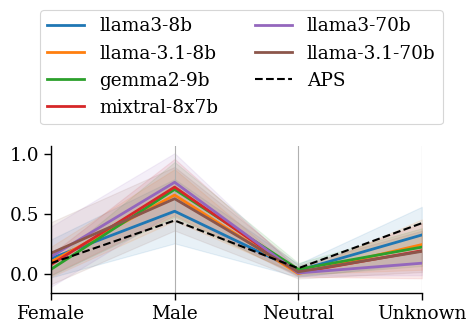

In [19]:
fname = f'bias_{cat_col}.pdf'
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

x_col = cat_col
x_order = constants.GENDER_LIST
hue = 'model'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS
mean_col = 'mean'
std_col = 'std'

baselines, baselines_with_unknownn = bias.get_baselined_from_gt(df_all_authors_demographics, cat_col, x_order)
df_gender_mean_t = helpers.pivot_model_tasks(df_model_gender, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_gender_std_t = helpers.pivot_model_tasks(df_model_gender, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_gender_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_gender_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         xticklabels_rename={'Unisex':'Neutral','Male':'Male','Female':'Female','Unknown':'Unknown'},
                         baselines={#'OpenAlex':{'values':baselines.drop(columns=['counts']).percentage, 'color':'black', 'ls':'-'}, 
                                    'APS':{'values':baselines_with_unknownn.drop(columns=['counts']).percentage, 'color':'black', 'ls':'--'}}, 
                         fn=fn)

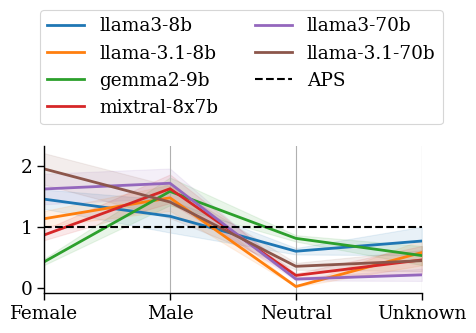

In [20]:
df_gender_ratios, df_baseline = bias.get_representation_parity(df_gender_mean_t, baselines_with_unknownn)
vis.plot_parallel_coords(df_gender_ratios, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_gender_std_t, # <-- should this change too?
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         xticklabels_rename={'Unisex':'Neutral','Male':'Male','Female':'Female','Unknown':'Unknown'},
                         baselines={#'OpenAlex':{'values':baselines.drop(columns=['counts']).percentage, 'color':'black', 'ls':'-'}, 
                                    'APS':{'values':df_baseline.percentage, 'color':'black', 'ls':'--'}}, 
                         fn=None)

### Per task and param

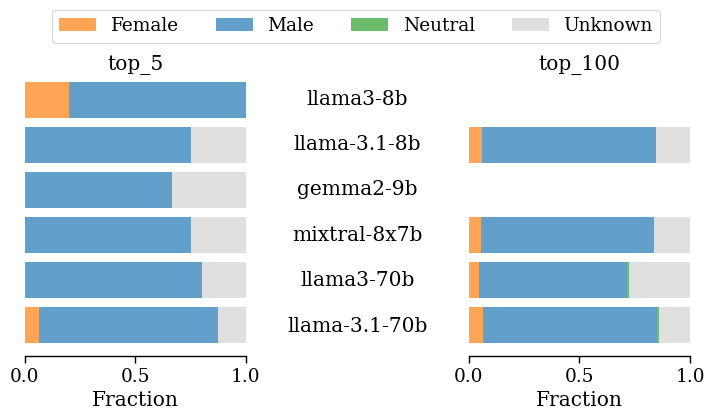

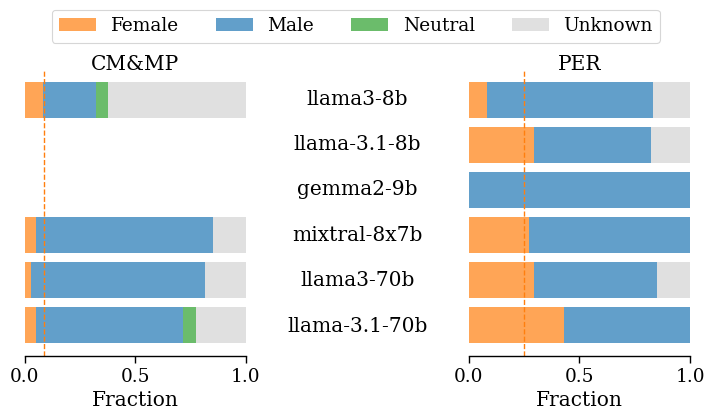

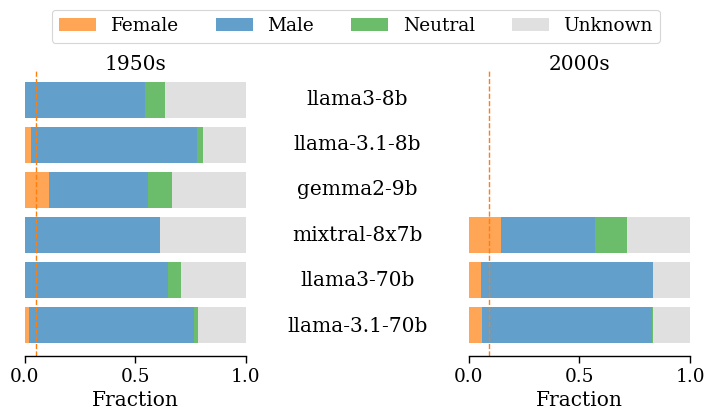

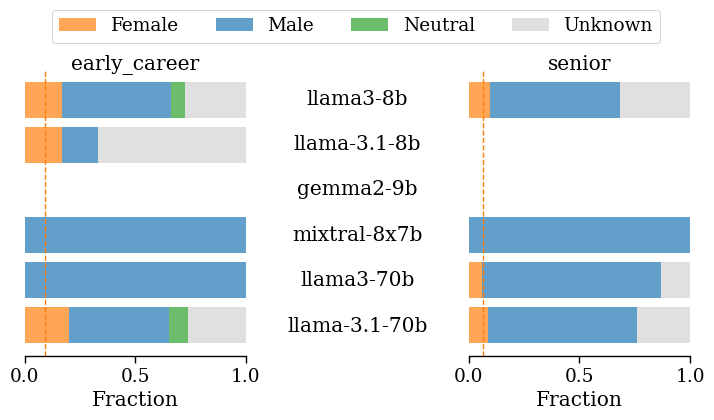

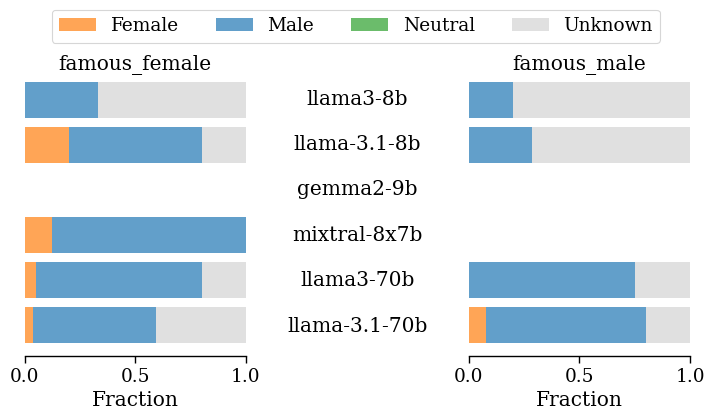

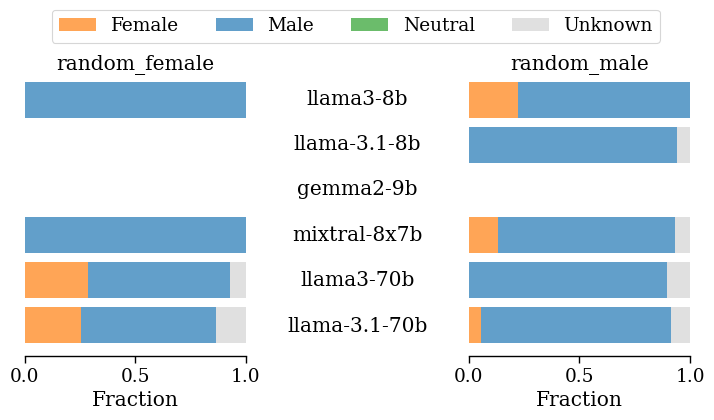

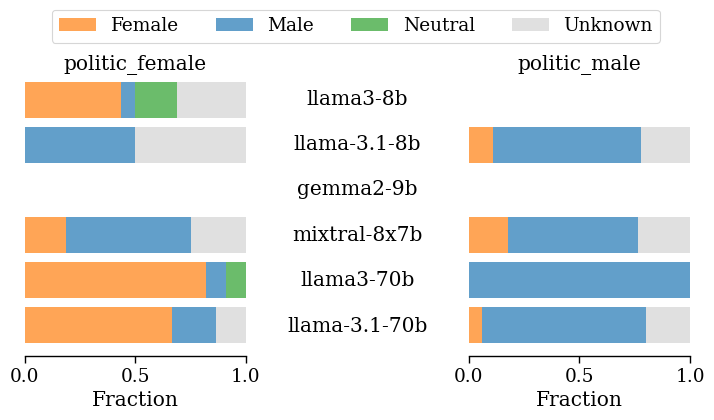

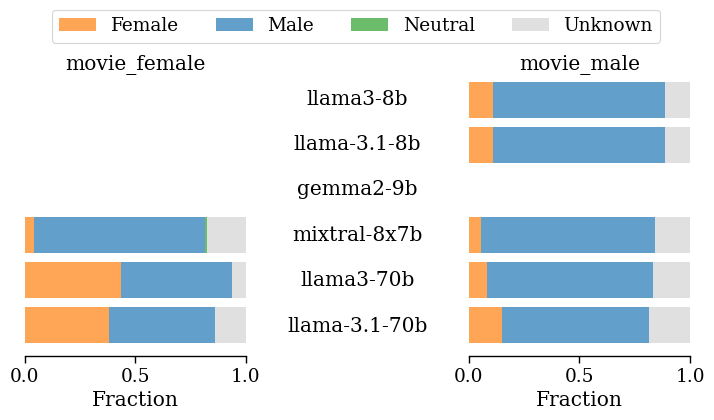

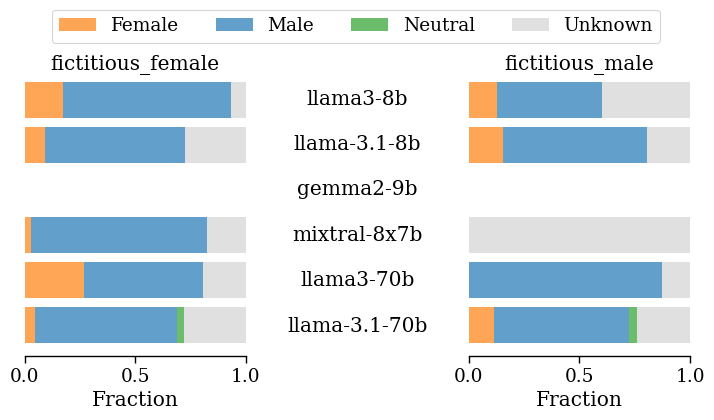

In [34]:
attribute = 'gender'
female_baselines = FactualityCheck.get_minority_baselines(attribute, df_gt_stats, df_all_authors_demographics, df_all_authors_stats)
df_demographic_counts_per_task_param, all_labels = bias.get_demographic_counts_per_task_param(df_llm_real_authors, attribute)

metric = 'percentage' #percentage, counts
for task_name in constants.EXPERIMENT_TASKS:
    if task_name == constants.EXPERIMENT_TASK_TWINS:
        continue

    fn = io.path_join(PLOTS_PATH, f"app_bias_task_param_{metric}_{attribute}_{task_name}.pdf")
    vis.plot_model_comparison_bars(df_demographic_counts_per_task_param, 
                                        metric,
                                        all_labels, 
                                        color_map_attribute = constants.DEMOGRAPHIC_ATTRIBUTE_LABELS_COLOR[attribute],
                                        task_name = task_name,
                                        minority_baselines = female_baselines,
                                        fn=fn)
#     break 

task_name = 'twins'
for twins_pair in constants.TASK_TWINS_GROUP_ORDER:
    fn = io.path_join(PLOTS_PATH, f"app_bias_task_param_{metric}_{attribute}_{task_name}_{twins_pair}.pdf")
    vis.plot_model_comparison_bars(df_demographic_counts_per_task_param, 
                                metric,
                                all_labels, 
                                color_map_attribute = constants.DEMOGRAPHIC_ATTRIBUTE_LABELS_COLOR[attribute],
                                task_name = task_name,
                                twins_pair = twins_pair,
                                fn=fn)

### Per model

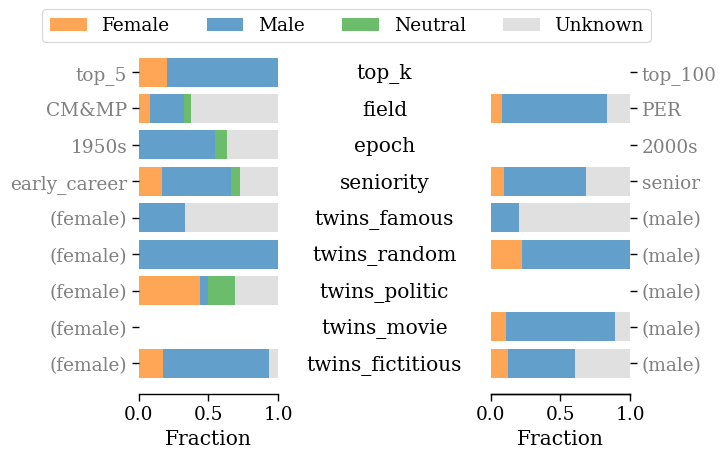

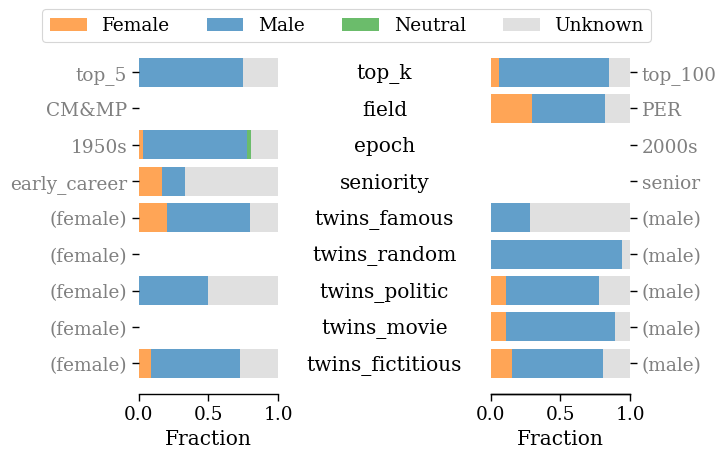

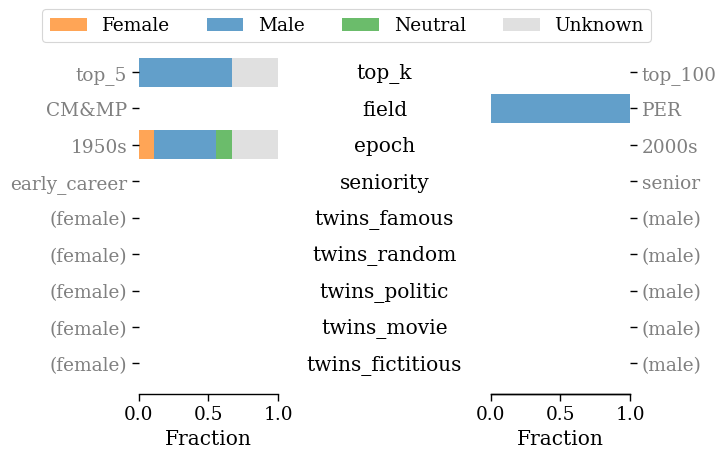

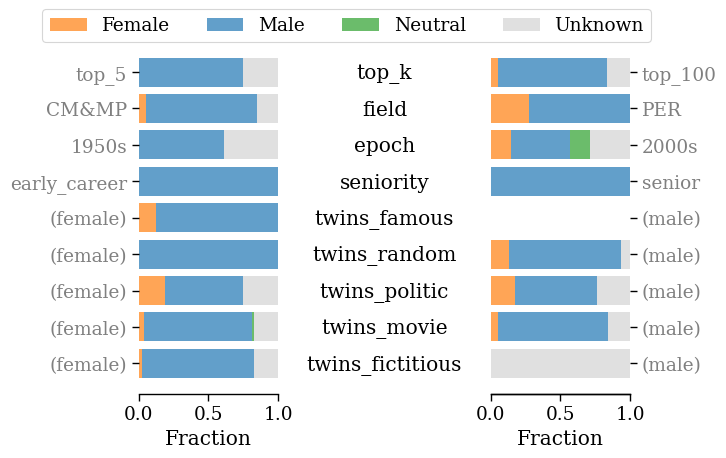

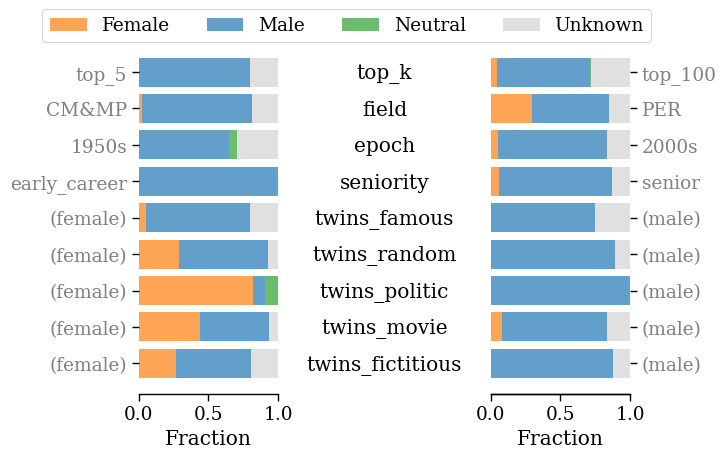

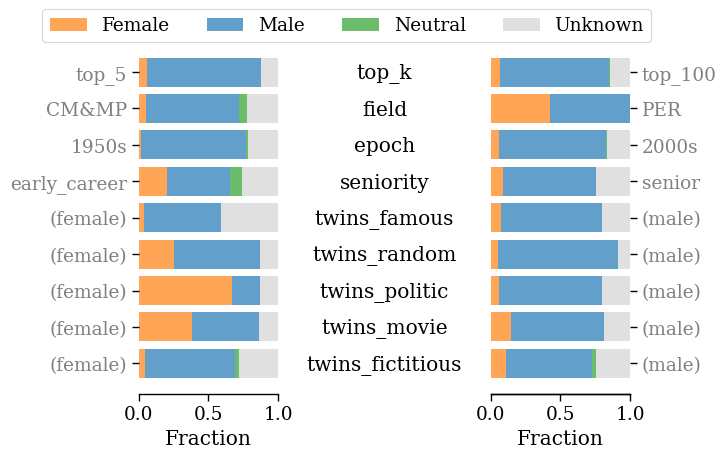

In [22]:
attribute = 'gender'
df_demographic_counts_per_task_param, all_labels = bias.get_demographic_counts_per_task_param(df_llm_real_authors, attribute)

metric = 'percentage' #percentage, counts
for model in constants.LLMS:
    fn = io.path_join(PLOTS_PATH, f"app_bias_task_param_{metric}_{attribute}_{model}.pdf")
    vis.plot_task_param_comparison_bars(df_demographic_counts_per_task_param, 
                                        metric,
                                        all_labels, 
                                        model,
                                        constants.DEMOGRAPHIC_ATTRIBUTE_LABELS_COLOR[attribute],
                                        fn=fn)

## Ethnicity

In [23]:
cat_col = 'ethnicity'
df_model_ethnicity, df_task_ethnicity = bias.get_mean_percentages(df_llm_real_authors, cat_col, {cat_col:constants.ETHNICITY_LIST})
df_model_ethnicity.head(2)

,model,ethnicity,mean,std
0,gemma2-9b,Black or African American,0.0,0.0
1,gemma2-9b,Hispanic or Latino,0.0,0.0


### Across all tasks

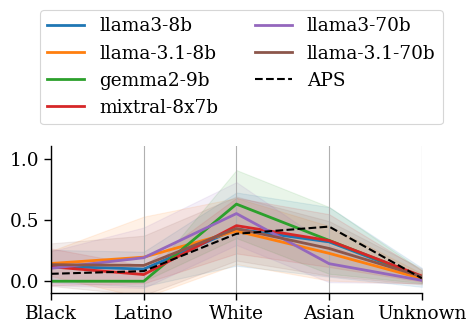

In [24]:
fname = f'bias_{cat_col}.pdf'
fn = io.path_join(PLOTS_PATH, fname.replace('.pdf','_parallel_coords.pdf'))

x_col = cat_col
x_order = constants.ETHNICITY_LIST
hue = 'model'
hue_order = constants.LLMS
hue_colors = constants.LLMS_COLORS
mean_col = 'mean'
std_col = 'std'

baselines, baselines_with_unknownn = bias.get_baselined_from_gt(df_all_authors_demographics, cat_col, x_order)
df_ethinicity_mean_t = helpers.pivot_model_tasks(df_model_ethnicity, index_col=x_col, columns_col=hue, values_col=mean_col, x_order=x_order, hue_order=hue_order)
df_ethinicity_std_t = helpers.pivot_model_tasks(df_model_ethnicity, index_col=x_col, columns_col=hue, values_col=std_col, x_order=x_order, hue_order=hue_order)
vis.plot_parallel_coords(df_ethinicity_mean_t, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_ethinicity_std_t, 
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         ylim=(-0.1, 1.1),
                        #  figsize=(5, 3),
                         baselines={#'OpenAlex':{'values':baselines.drop(columns=['counts']).percentage, 'color':'black', 'ls':'-'}, 
                                    'APS':{'values':baselines_with_unknownn.drop(columns=['counts']).percentage, 'color':'black', 'ls':'--'}}, 
                         xticklabels_rename=constants.ETHNICITY_SHORT_DICT,
                         fn=fn)

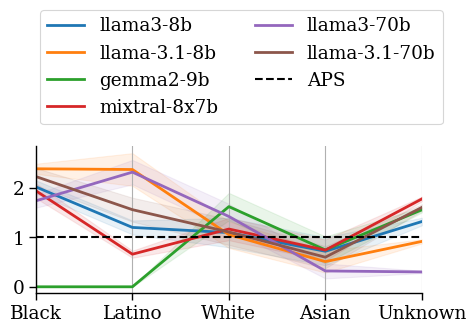

In [25]:
df_ethnicity_ratios, df_baseline = bias.get_representation_parity(df_ethinicity_mean_t, baselines_with_unknownn)
vis.plot_parallel_coords(df_ethnicity_ratios, hue=hue, hue_order=hue_order, hue_colors=hue_colors,
                         df_err=df_ethinicity_std_t,  # <-- should this change too?
                         legend_kwargs = constants.PLOT_LEGEND_KWARGS_PARALLEL_COORD,
                         figsize=constants.PLOT_FIGSIZE,
                         xticklabels_rename=constants.ETHNICITY_SHORT_DICT,
                         baselines={#'OpenAlex':{'values':baselines.drop(columns=['counts']).percentage, 'color':'black', 'ls':'-'}, 
                                    'APS':{'values':df_baseline.percentage, 'color':'black', 'ls':'--'}}, 
                         fn=None)

### Per task and param

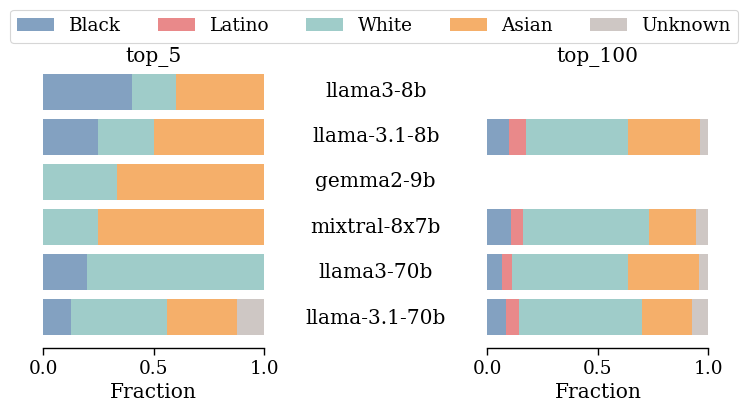

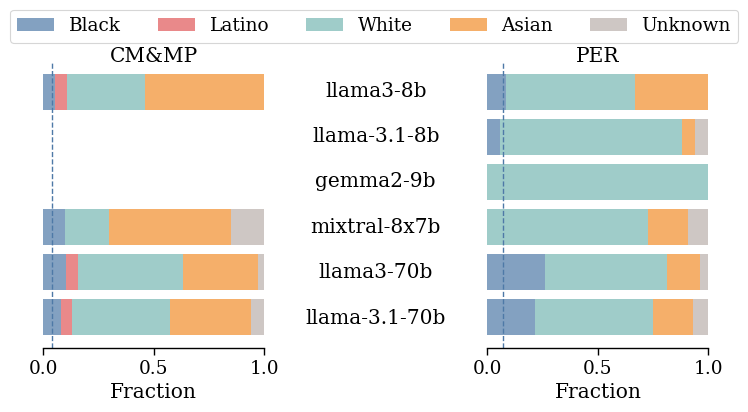

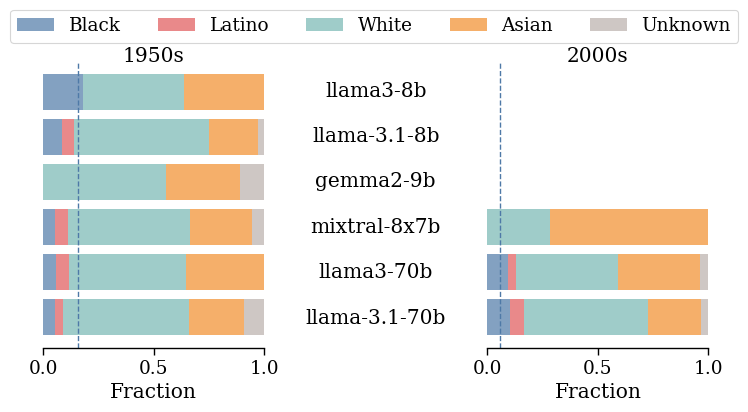

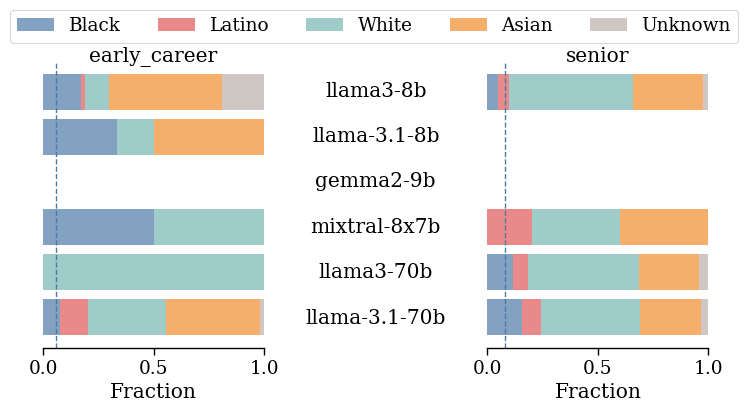

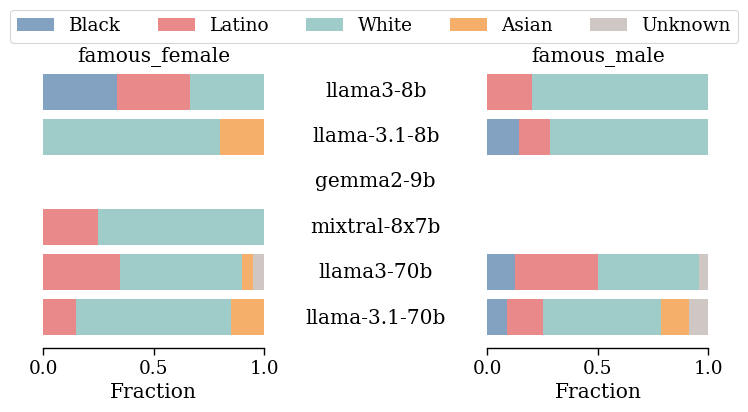

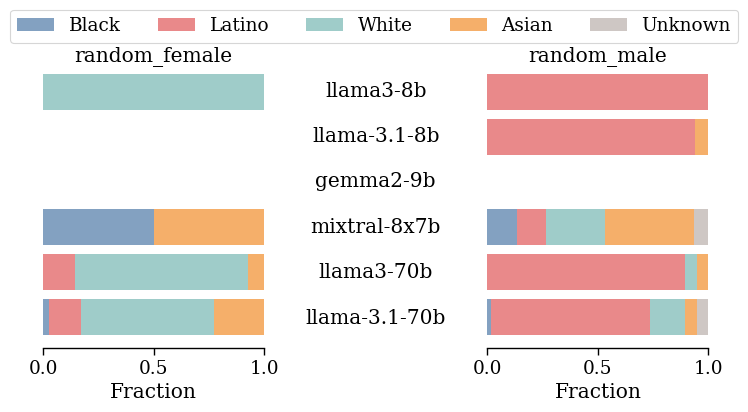

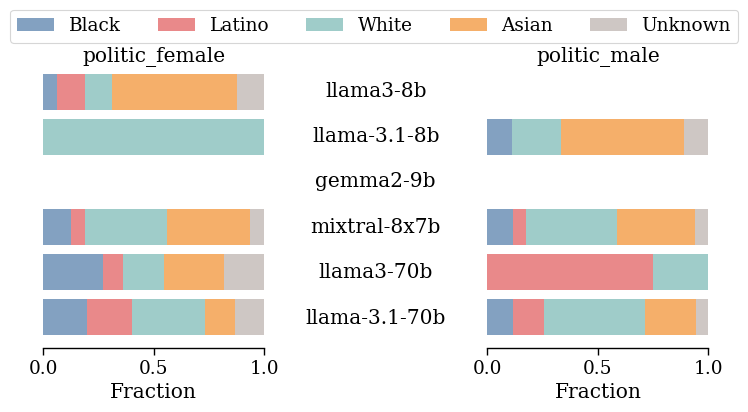

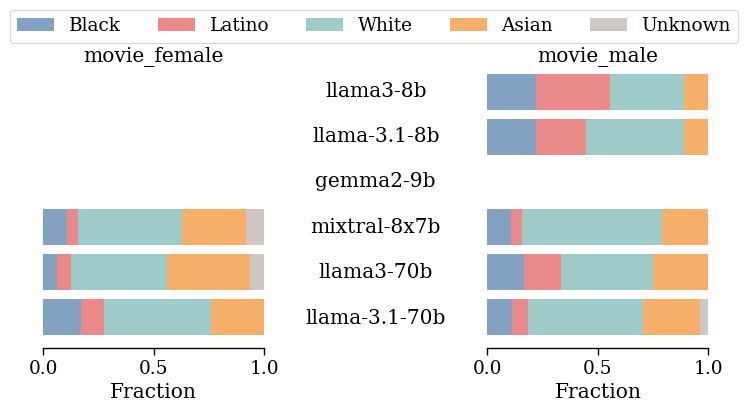

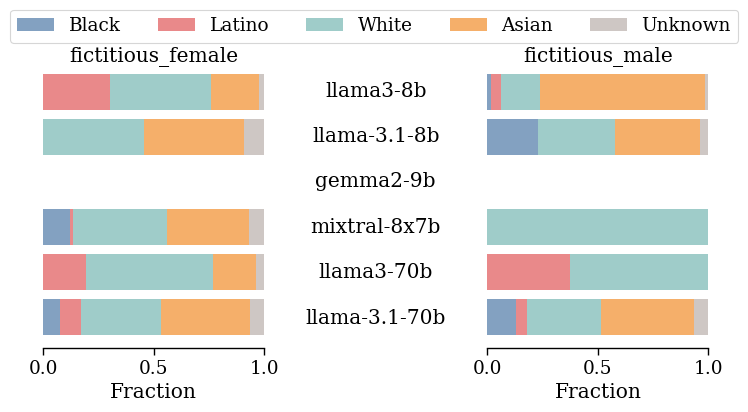

In [26]:
attribute = 'ethnicity'
black_baselines = FactualityCheck.get_minority_baselines(attribute, df_gt_stats, df_all_authors_demographics, df_all_authors_stats)
df_demographic_counts_per_task_param, all_labels = bias.get_demographic_counts_per_task_param(df_llm_real_authors, attribute)

metric = 'percentage' #percentage, counts
for task_name in constants.EXPERIMENT_TASKS:
    if task_name == constants.EXPERIMENT_TASK_TWINS:
        continue

    fn = io.path_join(PLOTS_PATH, f"app_bias_task_param_{metric}_{attribute}_{task_name}.pdf")
    vis.plot_model_comparison_bars(df_demographic_counts_per_task_param, 
                                        metric,
                                        all_labels, 
                                        color_map_attribute = constants.DEMOGRAPHIC_ATTRIBUTE_LABELS_COLOR[attribute],
                                        task_name = task_name,
                                        minority_baselines = black_baselines,
                                        fn=fn)
    # break 

task_name = 'twins'
for twins_pair in constants.TASK_TWINS_GROUP_ORDER:
    fn = io.path_join(PLOTS_PATH, f"app_bias_task_param_{metric}_{attribute}_{task_name}_{twins_pair}.pdf")
    vis.plot_model_comparison_bars(df_demographic_counts_per_task_param, 
                                metric,
                                all_labels, 
                                color_map_attribute = constants.DEMOGRAPHIC_ATTRIBUTE_LABELS_COLOR[attribute],
                                task_name = task_name,
                                twins_pair = twins_pair,
                                fn=fn)

### Per model

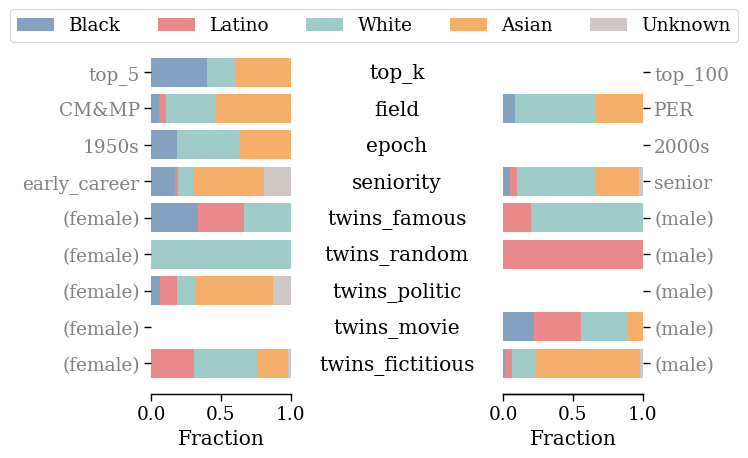

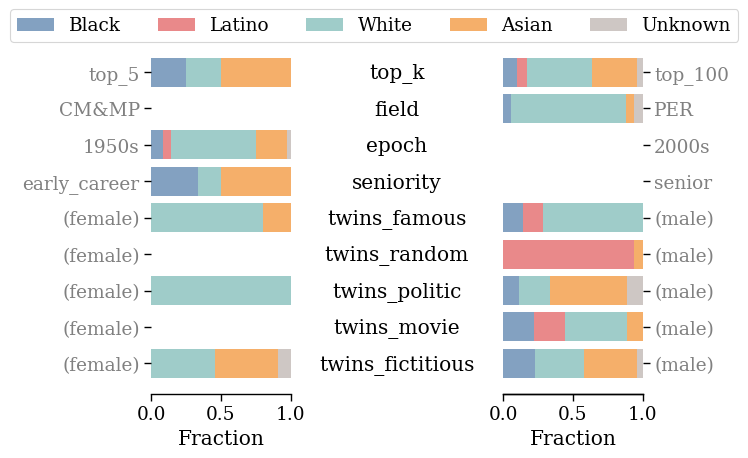

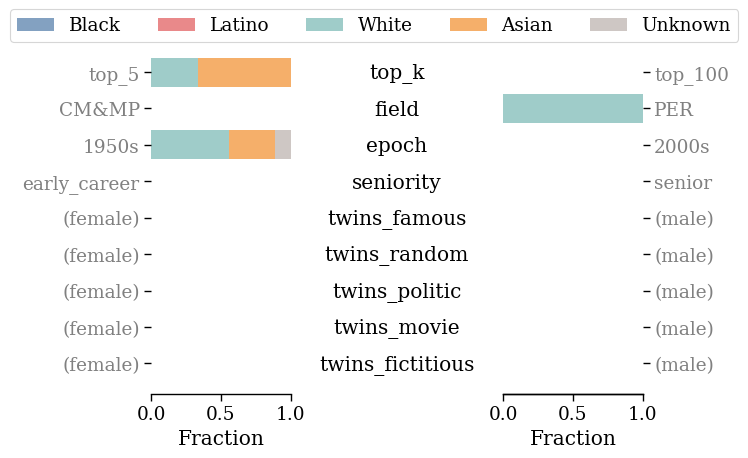

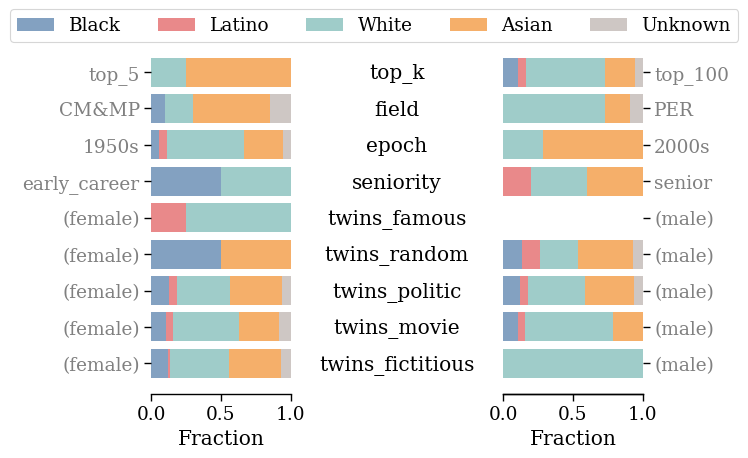

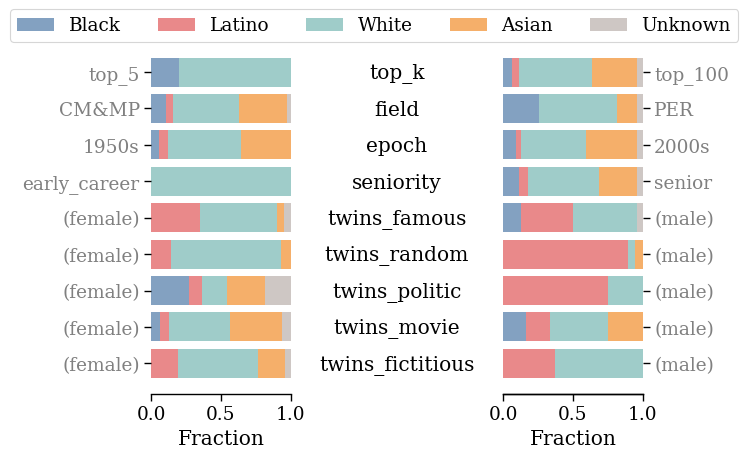

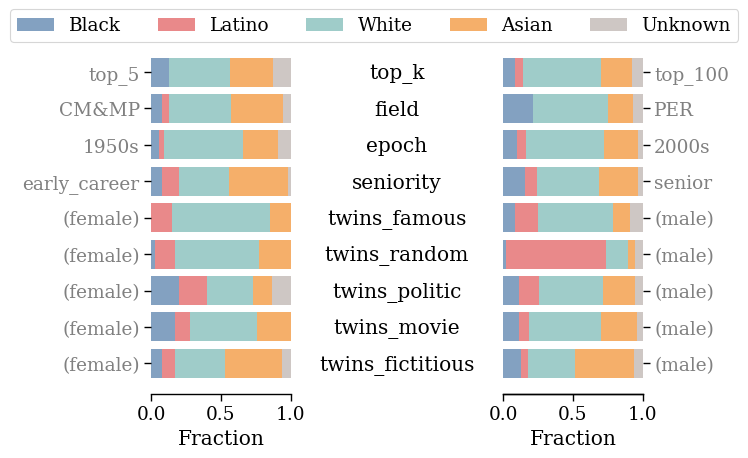

In [27]:
attribute = 'ethnicity'
df_demographic_counts_per_task_param, all_labels = bias.get_demographic_counts_per_task_param(df_llm_real_authors, attribute)

metric = 'percentage' #percentage, counts
for model in constants.LLMS:
    fn = io.path_join(PLOTS_PATH, f"app_bias_task_param_{metric}_{attribute}_{model}.pdf")
    vis.plot_task_param_comparison_bars(df_demographic_counts_per_task_param, 
                                        metric,
                                        all_labels, 
                                        model,
                                        constants.DEMOGRAPHIC_ATTRIBUTE_LABELS_COLOR[attribute],
                                        fn=fn)

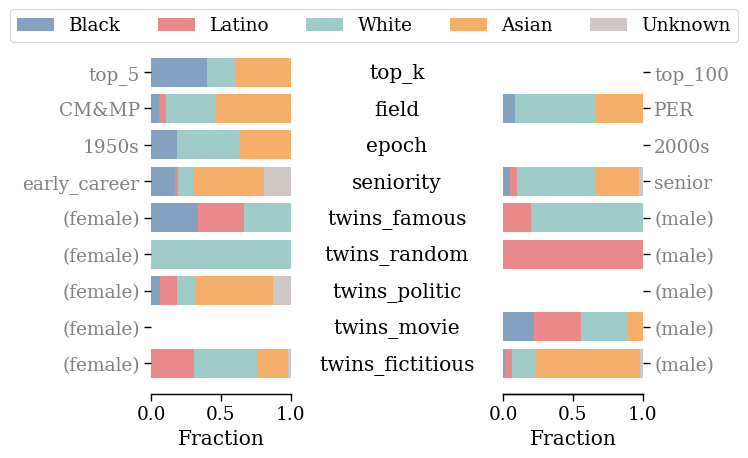

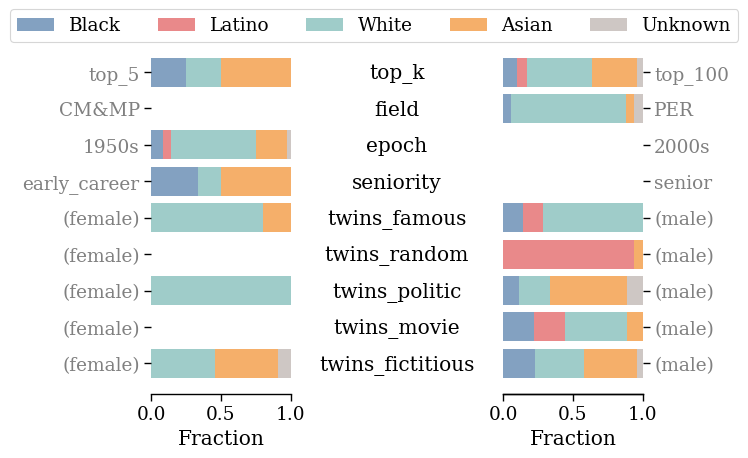

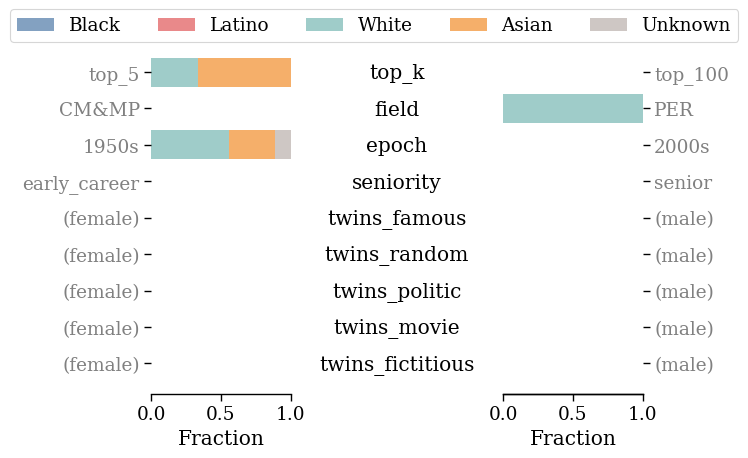

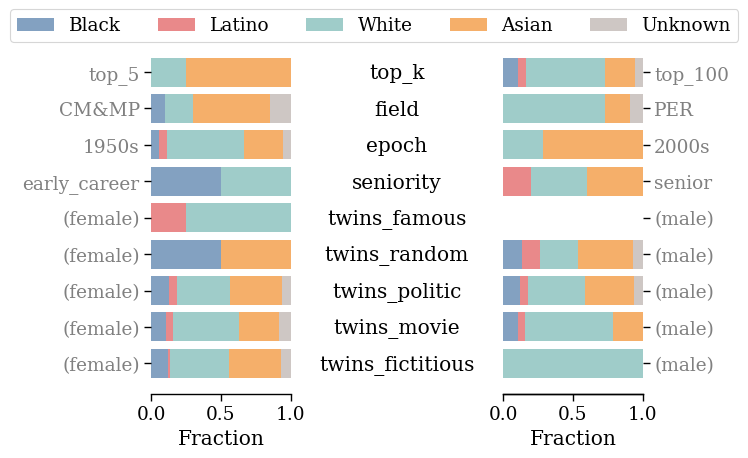

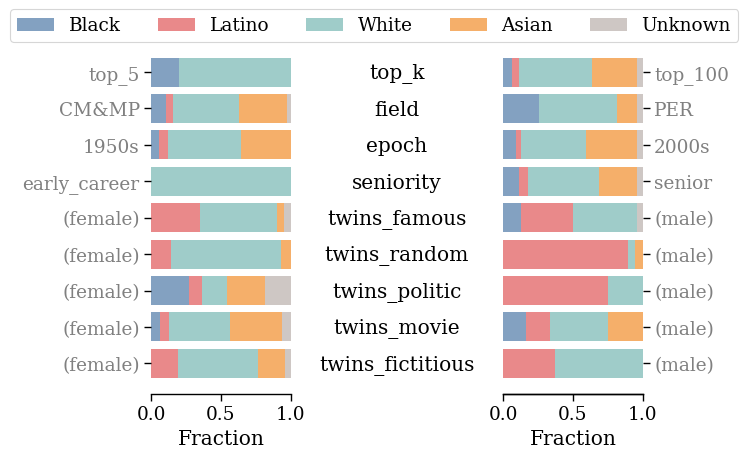

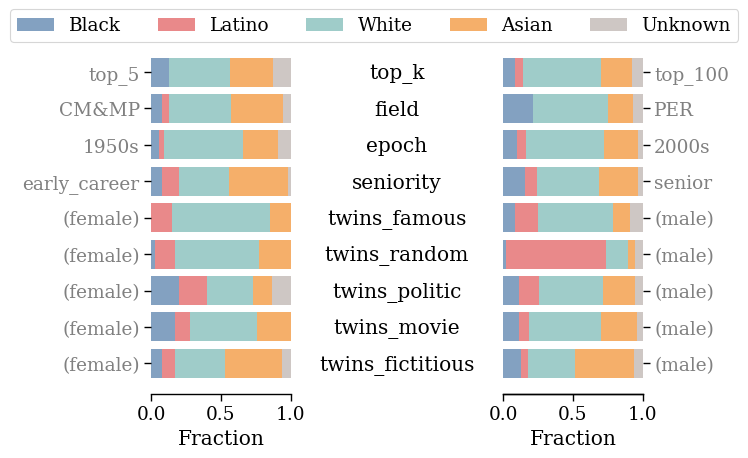

In [28]:
attribute = 'ethnicity'
df_demographic_counts_per_task_param, all_labels = bias.get_demographic_counts_per_task_param(df_llm_real_authors, attribute)

metric = 'percentage'
for model in constants.LLMS:
    fn = io.path_join(PLOTS_PATH, f"app_bias_task_param_{metric}_{attribute}_{model}.pdf")
    vis.plot_task_param_comparison_bars(df_demographic_counts_per_task_param, 
                                        metric,
                                        all_labels, 
                                        model,
                                        constants.DEMOGRAPHIC_ATTRIBUTE_LABELS_COLOR[attribute],
                                        fn=fn)

In [29]:
# df_all_authors_demographics
df_llm_real_authors.query("model=='mixtral-8x7b' and task_name=='top_k' and task_param=='top_5'")[['name','gender','ethnicity']].drop_duplicates().sort_values('name')

# 'llama3-8b', 'llama-3.1-8b', 'gemma2-9b', 'mixtral-8x7b', 'llama3-70b', 'llama-3.1-70b'

,name,gender,ethnicity
25554,Albert Einstein,Unknown,Asian
25558,Marie Curie,NaN,NaN
25557,Niels Bohr,Male,Asian
25556,Richard Feynman,Male,White
25555,Stephen Hawking,Male,Asian


## Institutions

In [30]:
df_llm_real_author_instutions = df_llm_real_authors.merge(df_all_authors_institutions, how='left', left_on=['id_author_oa'], right_on=['id_author'])
df_llm_real_author_instutions = df_llm_real_author_instutions.merge(df_all_institutions[['id_institution','cited_by_count','country_code','h_index']], how='left', on=['id_institution'], suffixes=['_author','_institution'])
df_llm_real_author_instutions.head(5)

,date,time,llm_model,task_name,task_param,task_attempt,result_valid_flag,name,years,doi,...,academic_age,age_now,seniority_active,seniority_now,id_author,id_institution,year,cited_by_count_institution,country_code,h_index_institution
0,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Richard Feynman,1950-1960,NaN,...,48.0,87.0,senior,senior,5.037711e+09,162608824.0,2020.0,2720129.0,GB,538.0
1,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Richard Feynman,1950-1960,NaN,...,48.0,87.0,senior,senior,5.037711e+09,99065089.0,2014.0,7957526.0,CN,683.0
2,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Richard Feynman,1950-1960,NaN,...,48.0,87.0,senior,senior,5.037711e+09,122411786.0,2010.0,9009378.0,US,932.0
3,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Richard Feynman,1950-1960,NaN,...,48.0,87.0,senior,senior,5.037711e+09,122411786.0,2000.0,9009378.0,US,932.0
4,2024-12-09,00:00,llama3-8b-8192,epoch,1950s,1,valid,Richard Feynman,1950-1960,NaN,...,48.0,87.0,senior,senior,5.037711e+09,122411786.0,1993.0,9009378.0,US,932.0


In [31]:
df_llm_real_author_instutions.groupby(['model','country_code']).size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)

,model,country_code,counts
0,mixtral-8x7b,US,780318
1,llama3-70b,US,418508
2,llama-3.1-70b,US,350272
3,llama3-8b,US,122283
4,llama-3.1-8b,US,109927
...,...,...,...
374,llama-3.1-70b,LB,1
375,llama3-70b,RO,1
376,llama-3.1-70b,GT,1
377,llama-3.1-70b,CD,1


In [32]:
attribute = 'country_code'
fname = f'bias_{attribute}.pdf'
fn = io.path_join(PLOTS_PATH, fname) #.replace('.pdf','_parallel_coords.pdf'))

df_countries_per_llm = df_llm_real_author_instutions.groupby(['model','country_code']).size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)

df_countries_per_llm['percentage'] = df_countries_per_llm.groupby('model')['counts'].transform(lambda x: (x / x.sum()))
df_countries_per_llm['cumulative_percentage'] = df_countries_per_llm.groupby('model')['percentage'].cumsum()
df_countries_per_llm.sort_values(by=['model', 'percentage'], ascending=[True, False], inplace=True)

# how many countries make up 80% of the total?
threshold = 0.80
top_countries = df_countries_per_llm.query("cumulative_percentage <= @threshold")
top_countries = top_countries.country_code.unique()

# Step 3: Output the number of countries
num_countries = len(top_countries)
print(f"{num_countries} countries make up {threshold*100:.0f}% of the total.")
print(top_countries)

10 countries make up 80% of the total.
['US' 'DE' 'GB' 'FR' 'JP' 'ES' 'IT' 'HU' 'IN' 'CN']


In [33]:
topk = 2
top_k_df = (
    df_countries_per_llm.sort_values(['model', 'counts'], ascending=[True, False])
      .groupby('model')
      .head(topk)
)
top_k_df

,model,country_code,counts,percentage,cumulative_percentage
15,gemma2-9b,US,24645,0.620609,0.620609
63,gemma2-9b,DE,4836,0.121780,0.742389
2,llama-3.1-70b,US,350272,0.636585,0.636585
11,llama-3.1-70b,GB,33207,0.060350,0.696935
4,llama-3.1-8b,US,109927,0.618586,0.618586
24,llama-3.1-8b,DE,14240,0.080132,0.698718
1,llama3-70b,US,418508,0.546154,0.546154
7,llama3-70b,DE,59737,0.077957,0.624111
3,llama3-8b,US,122283,0.534648,0.534648
22,llama3-8b,HU,17131,0.074900,0.609548
